# STAT-GB 2302 - Project 2

Same questions as Homework 8, which can be found [here](http://people.stern.nyu.edu/churvich/Forecasting/Homework/HW8.pdf)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults, ARIMAResults
from matplotlib.pyplot import acorr
import sys
print sys.version
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import Quandl
%pylab inline

2.7.11 (default, Dec  5 2015, 14:44:47) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [48]:
#data = Quandl.get("YAHOO/AAPL")
#data.to_csv('ford_stock.csv')
data = pd.read_csv('ford_stock.csv')
data.Date = pd.to_datetime(data.Date)
data.set_index('Date',inplace=True)
# # let's only look at stock price since 2009
data = data[data.index > '2008-01-01']
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2008-01-02,6.73,6.77,6.51,6.60,33242262
2008-01-03,6.66,6.66,6.41,6.45,47189431
2008-01-04,6.38,6.38,6.00,6.13,57780967
2008-01-07,6.21,6.30,6.10,6.16,47008662
2008-01-08,6.25,6.35,6.09,6.10,47965310


# Enter company name here to display in all graphs below:

In [49]:
name = 'Ford (F)'

## Question 1 - Plot the logs

In [50]:
data['log'] = [np.log(i) for i in data['Close']]
data['diff_log'] = data.log - data.log.shift(periods=-1)
data = data.dropna()
data.head()

,Open,High,Low,Close,Volume,log,diff_log
Date,,,,,,,
2008-01-02,6.73,6.77,6.51,6.60,33242262,1.887070,0.022990
2008-01-03,6.66,6.66,6.41,6.45,47189431,1.864080,0.050885
2008-01-04,6.38,6.38,6.00,6.13,57780967,1.813195,-0.004882
2008-01-07,6.21,6.30,6.10,6.16,47008662,1.818077,0.009788
2008-01-08,6.25,6.35,6.09,6.10,47965310,1.808289,0.004930


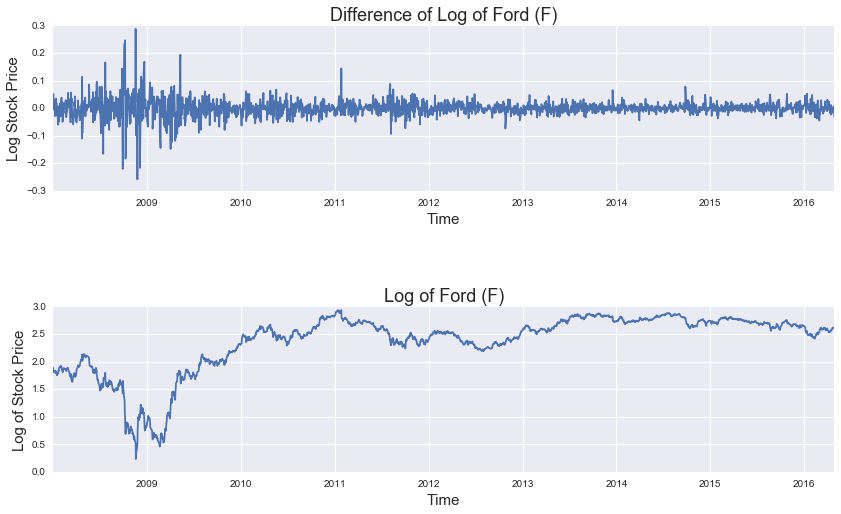

In [51]:
fig, ax = plt.subplots(figsize = (14,8))
fig.subplots_adjust(hspace=.7)

plt.subplot(211)
plt.plot(data.diff_log)
plt.title('Difference of Log of %s' % name, fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Log Stock Price', fontsize = 15)

plt.subplot(212)
plt.plot(data.log)
plt.title('Log of %s' % name, fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Log of Stock Price', fontsize = 15)

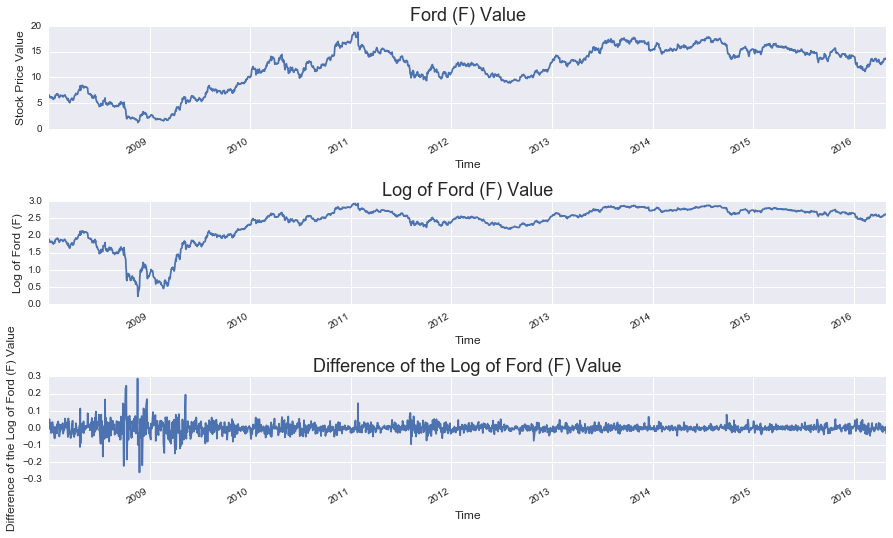

In [52]:
fig, ax = plt.subplots(figsize = (15,9))
fig.subplots_adjust(hspace=.7)

plt.subplot(311)
data.Close.plot()
plt.title('%s Value' % name, fontsize = 18)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Stock Price Value', fontsize =12)

plt.subplot(312)
data.log.plot()
plt.title('Log of %s Value' % name, fontsize = 18)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Log of %s' % name, fontsize =12)

plt.subplot(313)
data.diff_log.plot()
plt.title('Difference of the Log of %s Value' % name, fontsize = 18)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Difference of the Log of %s Value' % name, fontsize =12)

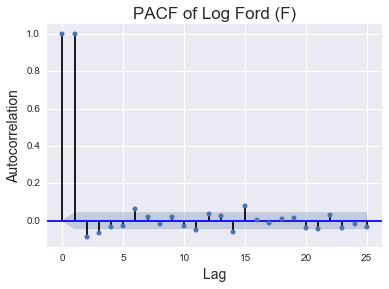

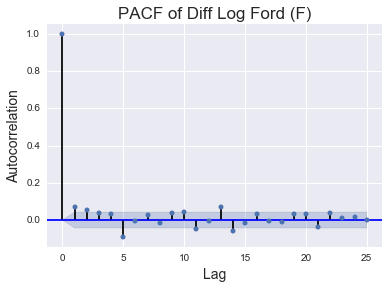

In [53]:
# plot the PACF
plot_pacf(data.log, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Log %s' % name, fontsize = 17)

plot_pacf(data.diff_log, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Diff Log %s' % name, fontsize = 17)

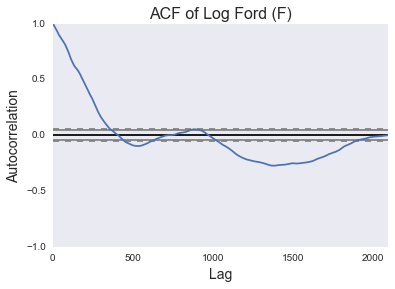

In [54]:
# then plot the ACF of log rupee
autocorrelation_plot(data.log)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Log %s' % name, fontsize= 16)

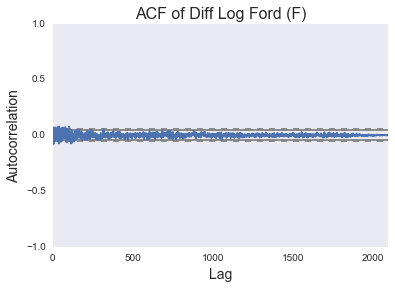

In [55]:
# then plot the ACF of the diff log rupee
autocorrelation_plot(data.diff_log)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Diff Log %s' % name, fontsize= 16)

In [56]:
#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(data.diff_log, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
   dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                -1.183540e+01
p-value                        7.812724e-22
# Lags Used                    1.300000e+01
Number of Observations Used    2.080000e+03
Critical Value (5%)           -2.862931e+00
Critical Value (1%)           -3.433498e+00
Critical Value (10%)          -2.567510e+00
dtype: float64


since the test statistic is lower than the 1% critical value, we can say we are 99% confident that the time series is stationary

## Question 2 - Model Selection

In [57]:
ararray = (data.log.dropna().as_matrix())

p=0
q=0
d=1
pdq=[]
aic=[]

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            
            #print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
                  
keys = pdq
values = aic
d = dict(zip(keys, values))

minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]

print 'The model with the lowest AIC score of %s' % np.round(x,4)
print 'Best described with an ARIMA(',p,d,q,') model'

The model with the lowest AIC score of -8659.8441
Best described with an ARIMA( 1 1 1 ) model


/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
model = ARIMA(ararray, (2,1,2)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2093
Model:                 ARIMA(2, 1, 2)   Log Likelihood                4335.922
Method:                       css-mle   S.D. of innovations              0.030
Date:                Tue, 03 May 2016   AIC                          -8659.844
Time:                        13:18:22   BIC                          -8625.966
Sample:                             1   HQIC                         -8647.433
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0003      0.001      0.423      0.672        -0.001     0.002
ar.L1.D.y     -0.2389      0.215     -1.110      0.267        -0.661     0.183
ar.L2.D.y      0.4240      0.151      2.805      0.0

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [59]:
# calculate the residuals (or errors)
prediction = pd.DataFrame(data.log[1:])
prediction['predict'] = np.exp(model.predict())
prediction['residuals'] = prediction.log - prediction.predict

In [60]:
prediction.head()

,log,predict,residuals
Date,,,
2008-01-03,1.864080,1.000343,0.863738
2008-01-04,1.813195,0.998201,0.814993
2008-01-07,1.818077,0.994445,0.823631
2008-01-08,1.808289,0.997232,0.811057
2008-01-09,1.803359,0.998929,0.804430


In [61]:
import statsmodels.stats.diagnostic
from pypr.stattest.ljungbox import *
import scipy.stats

In [62]:
# predict our ARIMA(0,1,1) model
pred = model.predict()
# then use ljung-box on our prediction
box = statsmodels.stats.diagnostic.acorr_ljungbox(pred, lags=25, boxpierce=False)
box

(array([  728.77928277,   900.28214279,   982.29766921,   991.82031088,
          991.88195479,   994.62813674,   994.74397648,   995.56387913,
          996.28569237,   998.59024993,   998.70291172,   998.86935738,
          999.84118993,  1004.07770794,  1007.73409738,  1007.92494607,
         1008.15370801,  1008.32846445,  1013.51549752,  1022.71924056,
         1025.6593833 ,  1033.10920572,  1041.49951332,  1044.77239927,
         1045.23168767]),
 array([  1.65058406e-160,   3.20786894e-196,   1.24530120e-212,
          2.11462735e-213,   3.43868062e-212,   1.29784367e-211,
          1.64589144e-210,   1.35405594e-209,   1.09008677e-208,
          3.76345448e-208,   3.65017246e-207,   3.27980577e-206,
          1.89136419e-205,   2.08736592e-205,   2.96394157e-205,
          2.25059874e-204,   1.62267884e-203,   1.16478086e-202,
          6.90920314e-203,   5.56941745e-204,   9.53690778e-204,
          1.75008367e-204,   1.99141807e-205,   2.73233222e-205,
          1.45660865e-

In [63]:
# calculate 1 step ahead forecast
numofsteps = 1
stepahead = model.forecast(numofsteps)[0]
ferrors = model.forecast(numofsteps)[2]

print'%s Step ahead forecast value is:' % numofsteps, np.exp(stepahead)
print '%s Step ahead 95 percent CI is:' % numofsteps, np.exp(ferrors)

1 Step ahead forecast value is: [ 13.66809968]
1 Step ahead 95 percent CI is: [[ 12.875397    14.50960688]]


# Question 3 - Plot ACF and PACF of Residuals

In [64]:
model.predict()

array([ 0.00034245, -0.00180035, -0.00557014, ...,  0.0003133 ,
        0.00034967,  0.00113121])

In [65]:
data = data[1:]
#data = data.reset_index()
data['prediction'] = model.predict()
data['resid'] = data.diff_log - data.prediction
data['sq_resid'] = [i**2 for i in data.resid]
data.head()

,Open,High,Low,Close,Volume,log,diff_log,prediction,resid,sq_resid
Date,,,,,,,,,,
2008-01-03,6.66,6.66,6.41,6.45,47189431,1.864080,0.050885,0.000342,0.050543,0.002555
2008-01-04,6.38,6.38,6.00,6.13,57780967,1.813195,-0.004882,-0.001800,-0.003082,0.000009
2008-01-07,6.21,6.30,6.10,6.16,47008662,1.818077,0.009788,-0.005570,0.015358,0.000236
2008-01-08,6.25,6.35,6.09,6.10,47965310,1.808289,0.004930,-0.002772,0.007702,0.000059
2008-01-09,6.11,6.14,5.76,6.07,77766593,1.803359,-0.029223,-0.001072,-0.028151,0.000792


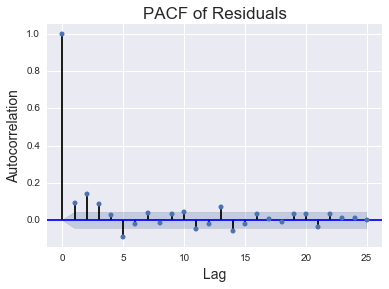

In [66]:
# then plot the PACF and ACF of the residuals
# first, the PACF

plot_pacf(data.resid, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Residuals', fontsize = 17)

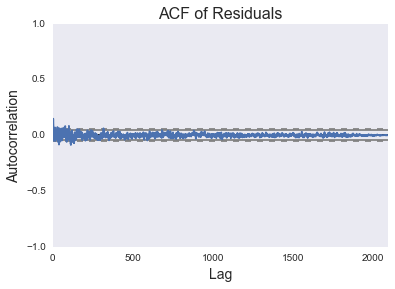

In [67]:
# then plot the ACF of log rupee
autocorrelation_plot(data.resid)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Residuals', fontsize= 16)

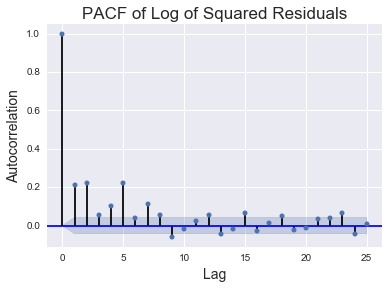

In [68]:
# then plot the PACF and ACF of the squared residuals
# first, the PACF

plot_pacf(data.sq_resid, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Log of Squared Residuals', fontsize = 17)

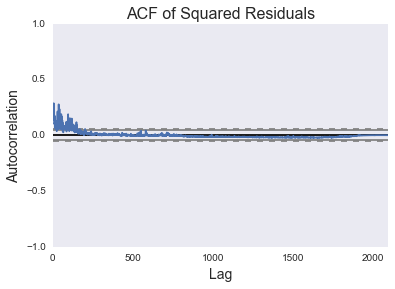

In [69]:
# then plot the ACF of log rupee
autocorrelation_plot(data.sq_resid)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Squared Residuals', fontsize= 16)

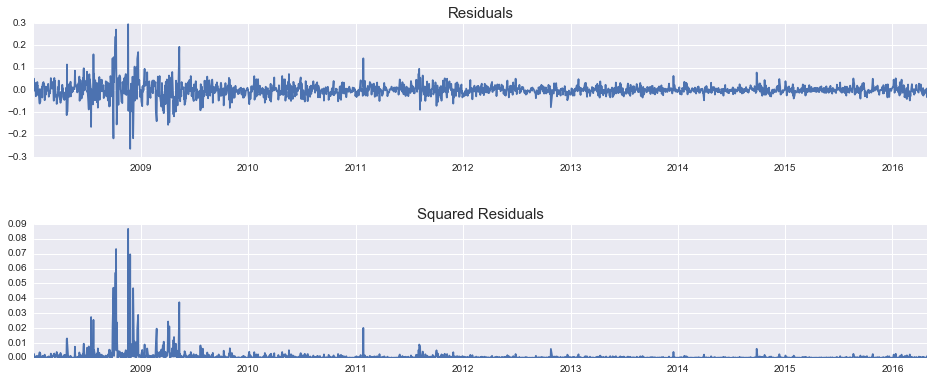

In [70]:
# plot residuals and squared residuals
fig, ax = plt.subplots(figsize = (16,6))
plt.subplots_adjust(hspace=.5)

plt.subplot(211)
plt.plot(data.resid)
plt.title('Residuals', fontsize = 15)

plt.subplot(212)
plt.plot(data.sq_resid)
plt.title('Squared Residuals', fontsize = 15)

In [71]:
data.head()

,Open,High,Low,Close,Volume,log,diff_log,prediction,resid,sq_resid
Date,,,,,,,,,,
2008-01-03,6.66,6.66,6.41,6.45,47189431,1.864080,0.050885,0.000342,0.050543,0.002555
2008-01-04,6.38,6.38,6.00,6.13,57780967,1.813195,-0.004882,-0.001800,-0.003082,0.000009
2008-01-07,6.21,6.30,6.10,6.16,47008662,1.818077,0.009788,-0.005570,0.015358,0.000236
2008-01-08,6.25,6.35,6.09,6.10,47965310,1.808289,0.004930,-0.002772,0.007702,0.000059
2008-01-09,6.11,6.14,5.76,6.07,77766593,1.803359,-0.029223,-0.001072,-0.028151,0.000792


# Question 4 - Log Likelihood

In [72]:
from arch import arch_model

In [73]:
my_list = []

for i in range(11):
    am = arch_model(data.resid, q=i);
    res = am.fit();
    my_list.append((res.loglikelihood,res.aic,i))

log_like = pd.DataFrame(my_list, columns = ['Log Likelihood','AIC','Lagged Volatility'])
log_like

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4565.86675036
Iteration:      2,   Func. Count:     17,   Neg. LLF: -4565.97156154
Iteration:      3,   Func. Count:     26,   Neg. LLF: -4566.33725692
Iteration:      4,   Func. Count:     38,   Neg. LLF: -4566.70676108
Iteration:      5,   Func. Count:     48,   Neg. LLF: -4566.71214816
Iteration:      6,   Func. Count:     60,   Neg. LLF: -4566.71840753
Iteration:      7,   Func. Count:     68,   Neg. LLF: -4574.46235623
Iteration:      8,   Func. Count:     76,   Neg. LLF: -4576.28358644
Iteration:      9,   Func. Count:     82,   Neg. LLF: -4608.22697338
Iteration:     10,   Func. Count:     88,   Neg. LLF: -4616.87892952
Iteration:     11,   Func. Count:     94,   Neg. LLF: -4658.50479351
Iteration:     12,   Func. Count:    101,   Neg. LLF: -4660.89969879
Iteration:     13,   Func. Count:    106,   Neg. LLF: -4667.63982544
Iteration:     14,   Func. Count:    111,   Neg. LLF: -4669.38958399
Iteration:     15,   Func. Count: 

,Log Likelihood,AIC,Lagged Volatility
0,4669.572542,-9333.145084,0
1,4978.519201,-9949.038402,1
2,4987.227718,-9964.455436,2
3,4994.814759,-9977.629517,3
4,4997.281463,-9980.562925,4
5,5001.287205,-9986.574410,5
6,5002.114598,-9986.229196,6
7,5000.547637,-9981.095273,7
8,4998.491192,-9974.982383,8
9,4996.875108,-9969.750216,9


In [74]:
min(log_like['AIC'])

-9986.574410312518

In [75]:
q = int(log_like[log_like['AIC'] == min(log_like['AIC'])].iloc[0,2])
q

5

In [76]:
bestarchmod = arch_model(data.log, q = q)

In [77]:
bestarchmod = bestarchmod.fit()
bestarchmod.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 551.096410513
Iteration:      2,   Func. Count:     29,   Neg. LLF: 103.426468489
Iteration:      3,   Func. Count:     41,   Neg. LLF: 92.5305516054
Iteration:      4,   Func. Count:     54,   Neg. LLF: 85.7138420594
Iteration:      5,   Func. Count:     66,   Neg. LLF: -47.7823111023
Iteration:      6,   Func. Count:     78,   Neg. LLF: -58.5607579141
Iteration:      7,   Func. Count:     89,   Neg. LLF: -199.141785536
Iteration:      8,   Func. Count:    104,   Neg. LLF: -200.012203707
Iteration:      9,   Func. Count:    115,   Neg. LLF: -222.357144482
Iteration:     10,   Func. Count:    125,   Neg. LLF: -252.27939533
Iteration:     11,   Func. Count:    136,   Neg. LLF: -282.970363937
Iteration:     12,   Func. Count:    151,   Neg. LLF: -283.583071024
Iteration:     13,   Func. Count:    161,   Neg. LLF: -401.533884206
Iteration:     14,   Func. Count:    176,   Neg. LLF: -401.937172449
Iteration:     15,   Func. Count:    18

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    log   R-squared:                      -0.379
Mean Model:             Constant Mean   Adj. R-squared:                 -0.379
Vol Model:                      GARCH   Log-Likelihood:                425.539
Distribution:                  Normal   AIC:                          -835.079
Method:            Maximum Likelihood   BIC:                          -789.908
                                        No. Observations:                 2093
Date:                Tue, May 03 2016   Df Residuals:                     2085
Time:                        13:18:25   Df Model:                            8
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             2.6890  4.612e-03    583.111      0.000       [  2.680,  2.698]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      2.6435e-03  9.780e-06    270.293      0.000   [2.624e-03,2.663e-03]
alpha[1]       0.8356  3.040e-03    274.832      0.000       [  0.830,  0.842]
beta[1]    2.0077e-05      8.611  2.332e-06      1.000       [-16.877, 16.877]
beta[2]    2.1042e-05     76.337  2.756e-07      1.000  [-1.496e+02,1.496e+02]
beta[3]    2.1925e-05    192.809  1.137e-07      1.000  [-3.779e+02,3.779e+02]
beta[4]    2.2926e-05      0.704  3.258e-05      1.000       [ -1.379,  1.379]
beta[5]    2.3755e-05      2.317  1.025e-05      1.000       [ -4.542,  4.542]
==============================================================================

Covariance estimator: robust
"""

In [78]:
am = arch_model(data.log, q=2, vol='GARCH')
garch = am.fit()
print garch.aic
print garch.loglikelihood

Iteration:      1,   Func. Count:      7,   Neg. LLF: 526.790415079
Iteration:      2,   Func. Count:     23,   Neg. LLF: 76.439509155
Iteration:      3,   Func. Count:     36,   Neg. LLF: 61.0535897725
Iteration:      4,   Func. Count:     44,   Neg. LLF: -69.9248724495
Iteration:      5,   Func. Count:     53,   Neg. LLF: -111.722161479
Iteration:      6,   Func. Count:     67,   Neg. LLF: -146.885790067
Iteration:      7,   Func. Count:     79,   Neg. LLF: -148.143263964
Iteration:      8,   Func. Count:     87,   Neg. LLF: -295.895225977
Iteration:      9,   Func. Count:     99,   Neg. LLF: -298.603387813
Iteration:     10,   Func. Count:    107,   Neg. LLF: -305.437720756
Iteration:     11,   Func. Count:    115,   Neg. LLF: -347.196430701
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -347.196433264
            Iterations: 15
            Function evaluations: 115
            Gradient evaluations: 11
-684.392866529
347.196433264

In [98]:
print 'ARCH Model, Q=5 (Best):' 
print 'ARCH with Q=5 AIC is %s' % bestarchmod.aic
print 'ARCH with Q=5 Log Likelihood is %s' % bestarchmod.loglikelihood
print ''
print 'GARCH Model, Q=2:'
print 'GARCH AIC is %s' % garch.aic
print 'GARCH Log Likelihood is %s' % garch.loglikelihood

ARCH Model, Q=5 (Best):
ARCH with Q=5 AIC is -835.078662135
ARCH with Q=5 Log Likelihood is 425.539331067

GARCH Model, Q=2:
GARCH AIC is -684.392866529
GARCH Log Likelihood is 347.196433264


Since our ARCH model with q=2 has the lower AIC score, we decide to use that for our foreacst

In [80]:
# calculate one step ahead forecast
# remember that since we are forecasting the logs, we need to take the exponent to convert back to actual rupee values
print 'Our one step ahead forecast using the ARCH(1,1) model with Q=1 is %s' % np.exp(bestarchmod.forecast())

Our one step ahead forecast using the ARCH(1,1) model with Q=1 is                   h.1
Date                 
2008-01-03  14.717503
2008-01-04  14.717503
2008-01-07  14.717503
2008-01-08  14.717503
2008-01-09  14.717503
2008-01-10  14.717503
2008-01-11  14.717503
2008-01-14  14.717503
2008-01-15  14.717503
2008-01-16  14.717503
2008-01-17  14.717503
2008-01-18  14.717503
2008-01-22  14.717503
2008-01-23  14.717503
2008-01-24  14.717503
2008-01-25  14.717503
2008-01-28  14.717503
2008-01-29  14.717503
2008-01-30  14.717503
2008-01-31  14.717503
2008-02-01  14.717503
2008-02-04  14.717503
2008-02-05  14.717503
2008-02-06  14.717503
2008-02-07  14.717503
2008-02-08  14.717503
2008-02-11  14.717503
2008-02-12  14.717503
2008-02-13  14.717503
2008-02-14  14.717503
...               ...
2016-03-16  14.717503
2016-03-17  14.717503
2016-03-18  14.717503
2016-03-21  14.717503
2016-03-22  14.717503
2016-03-23  14.717503
2016-03-24  14.717503
2016-03-28  14.717503
2016-03-29  14.717503
2016-03-30

# Question 6 - Plotting Conditional Variances

In [81]:
cond_var = bestarchmod.conditional_volatility**2

# add to our big dataframe
data['cond_var'] = cond_var
data.head()

,Open,High,Low,Close,Volume,log,diff_log,prediction,resid,sq_resid,cond_var
Date,,,,,,,,,,,
2008-01-03,6.66,6.66,6.41,6.45,47189431,1.864080,0.050885,0.000342,0.050543,0.002555,0.245189
2008-01-04,6.38,6.38,6.00,6.13,57780967,1.813195,-0.004882,-0.001800,-0.003082,0.000009,0.571317
2008-01-07,6.21,6.30,6.10,6.16,47008662,1.818077,0.009788,-0.005570,0.015358,0.000236,0.643636
2008-01-08,6.25,6.35,6.09,6.10,47965310,1.808289,0.004930,-0.002772,0.007702,0.000059,0.636518
2008-01-09,6.11,6.14,5.76,6.07,77766593,1.803359,-0.029223,-0.001072,-0.028151,0.000792,0.650852


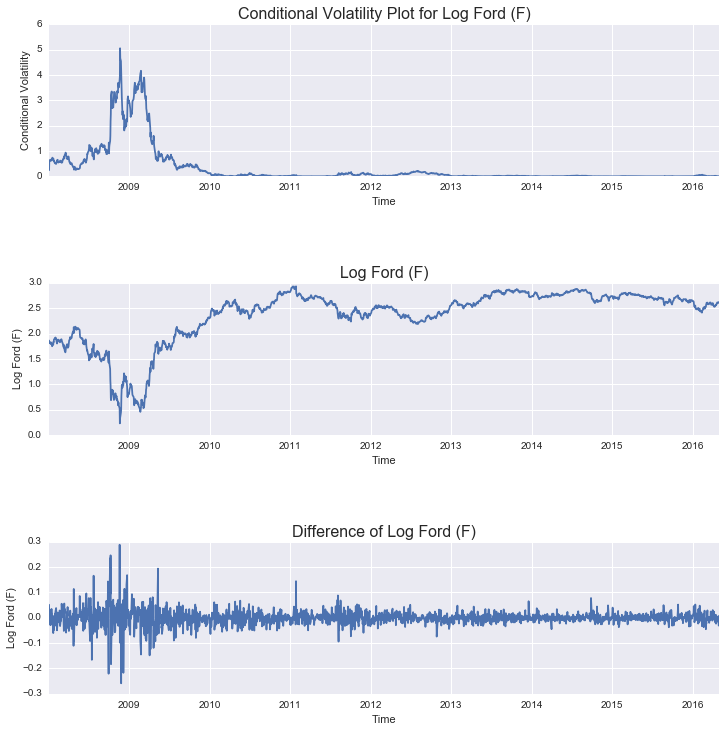

In [82]:
fig, ax = plt.subplots(figsize = (12,12))
fig.subplots_adjust(hspace=.7)

plt.subplot(311)
plt.plot(data.cond_var)
plt.title('Conditional Volatility Plot for Log %s' % name, fontsize=16)
plt.xlabel('Time')
plt.ylabel('Conditional Volatility')

plt.subplot(312)
plt.plot(data.log)
plt.title('Log %s' % name, fontsize=16)
plt.xlabel('Time')
plt.ylabel('Log %s' % name)

plt.subplot(313)
plt.plot(data.diff_log)
plt.title('Difference of Log %s' % name,fontsize=16)
plt.xlabel('Time')
plt.ylabel('Log %s' % name)

In [83]:
conf_ints = np.exp(garch.conf_int())
conf_ints

,lower,upper
mu,14.305445,14.322298
omega,1.002911,1.002912
alpha[1],1.632555,1.637833
beta[1],1.007883,1.433246
beta[2],1.043897,1.383798


In [84]:
my_pred = garch.resid
#my_pred = my_pred[1:]
my_pred.ix[:3]


Date
2008-01-03   -0.797149
2008-01-04   -0.848034
2008-01-07   -0.843152
Name: resid, dtype: float64

In [85]:
# data['arch_resid'] = my_pred + bestarchmod.resid
data['bestarchmod'] = bestarchmod.resid + data.log
data['my_pred'] = my_pred
#data['arch_resid'] = data.bestarchmod + data.my_pred
data['arch_resid'] = data.log + data.bestarchmod
data['upper_bound'] = data.bestarchmod +  conf_ints.loc['alpha[1]','upper']
data['lower_bound'] = data.bestarchmod - conf_ints.loc['alpha[1]','lower']
data.head()

,Open,High,Low,Close,Volume,log,diff_log,prediction,resid,sq_resid,cond_var,bestarchmod,my_pred,arch_resid,upper_bound,lower_bound
Date,,,,,,,,,,,,,,,,
2008-01-03,6.66,6.66,6.41,6.45,47189431,1.864080,0.050885,0.000342,0.050543,0.002555,0.245189,1.039123,-0.797149,2.903203,2.676955,-0.593432
2008-01-04,6.38,6.38,6.00,6.13,57780967,1.813195,-0.004882,-0.001800,-0.003082,0.000009,0.571317,0.937352,-0.848034,2.750547,2.575185,-0.695203
2008-01-07,6.21,6.30,6.10,6.16,47008662,1.818077,0.009788,-0.005570,0.015358,0.000236,0.643636,0.947116,-0.843152,2.765193,2.584949,-0.685439
2008-01-08,6.25,6.35,6.09,6.10,47965310,1.808289,0.004930,-0.002772,0.007702,0.000059,0.636518,0.927540,-0.852940,2.735829,2.565373,-0.705015
2008-01-09,6.11,6.14,5.76,6.07,77766593,1.803359,-0.029223,-0.001072,-0.028151,0.000792,0.650852,0.917680,-0.857870,2.721038,2.555512,-0.714875


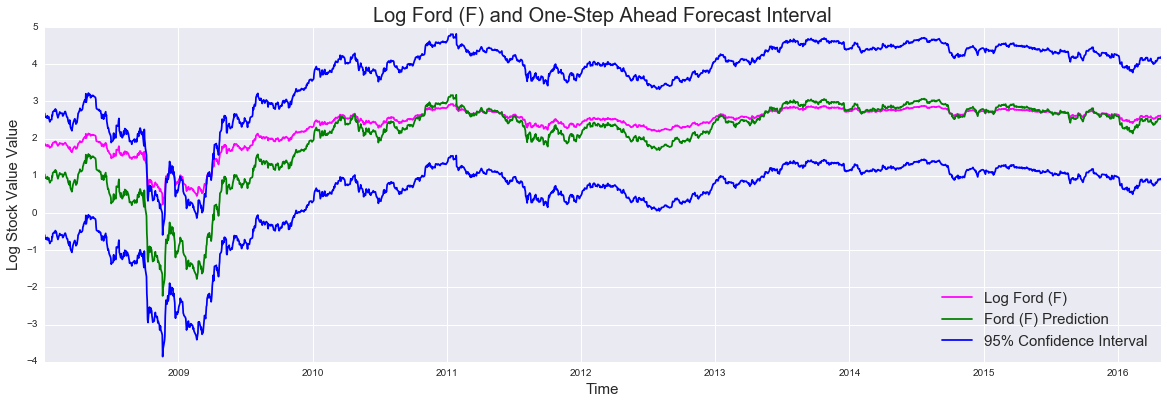

In [86]:
fig, ax = plt.subplots(figsize=(20,6))

plt.subplot(111)
#plt.plot(data.Date, data.arch_resid, label = 'ARCH Residuals', color = 'purple')
plt.plot(data.log, label = 'Log %s' % name, color='magenta')
plt.plot(data.bestarchmod, label = '%s Prediction' % name, color='green')
plt.plot(data.upper_bound, label = '95% Confidence Interval', c = 'blue')
plt.plot(data.lower_bound, color = 'blue', label = '')
plt.title('Log %s and One-Step Ahead Forecast Interval' % name, fontsize = 20)
plt.legend(loc = 4, fontsize = 15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Log Stock Value Value', fontsize = 15)
#plt.ylim(0, 30)


# Question 8 - Compute Residuals for ARIMA/ARCH Model

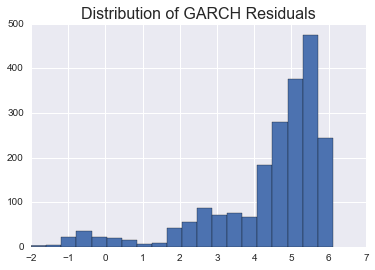

In [87]:
data.arch_resid.hist(bins = 20)
plt.title('Distribution of GARCH Residuals', size=16)

# Question 9 - How did the model do?

In [88]:
data['fail_upper'] = data.log > data.upper_bound
data['fail_lower'] = data.log < data.lower_bound

In [89]:
data.fail_lower.value_counts()

False    2093
Name: fail_lower, dtype: int64

In [90]:
data.fail_upper.value_counts()

False    1983
True      110
Name: fail_upper, dtype: int64

In [91]:
x = 140.0
y=2093
x/y

0.06688963210702341

In [99]:
# arch conf level
up = 14.717 + conf_ints.loc['alpha[1]','upper']
low = 14.717 - conf_ints.loc['alpha[1]','lower']

In [100]:
print up, low

16.3548326192 13.08444521
